### Run in Google Colab

Click the button below to open and run this notebook in Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/relmonta/hyphai/blob/master/examples/hyphaicc-1_forecast_example.ipynb)


# An example of using the HyPhAICC-1 model

This notebook shows an example of using the HyPhAICC-1 model for 
cloud cover nowcasting. The model is described in the paper related to this
repository. The model is trained on the METEOSAT Second Generation (MSG) satellite images,
these images have been preprocessed to describe the different [cloud types](https://www.nwcsaf.org/ct_description). 
The time step of the observations is 15 minutes, and the images have
a spatial resolution of 4.5 km. 

The model is trained to predict the cloud cover in the next 2 hours, given
the last 4 observations of cloud cover.

In [1]:
# If you are using google colab, get the package from github and install it
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
if IN_COLAB:
    ! git clone https://github.com/relmonta/hyphai.git
    import os 
    os.chdir('/content/hyphai/src')
    ! pip install -e .
    os.chdir('/content/hyphai/examples') 

In [2]:
# Import necessary libraries
import numpy as np
import torch
from hyphai.models import HyPhAI1
from hyphai.utils import *
from IPython.display import Image as ipyImage

In [3]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Setup

In [4]:
# Load satellite images
FNAME = '202101021200'
# Number of observations to use as input to the U-Net-Xception to produce the velocity field
CONTEXT_SIZE = 4
# Number of time steps to predict
MAX_LEAD_TIME = 8
# Number of cloud types
N_CLASSES = 12
IN_SHAPE = (256, 256) # You can change the input shape but it must be divisible by 16
BOUNDS = (280, 1740, *IN_SHAPE)

## Load the data
A data sample is provided in the `data` folder. They are 2D numpy arrays of size 3712x3712. With labels
ranging from 0 to 15. For more details refer to [provider description](https://www.nwcsaf.org/ct_description).
In this application, we use only the cloud cover labels.

The given sample is composed of 12 observations from 2021-01-02 11:15 to 2021-01-02 14:00.

In [5]:
# Loading the context observation + the ground truth for comparison with the predictions
sample = np.zeros((CONTEXT_SIZE + MAX_LEAD_TIME, *IN_SHAPE))
for t in range(-CONTEXT_SIZE, MAX_LEAD_TIME):
    sample[t + CONTEXT_SIZE] = load_data(FNAME, t+1, bounds=BOUNDS)
sample = sample.astype(int)
# Context observations
context = sample[:CONTEXT_SIZE].copy() 
# One-hot encode the initial state, resulting in an array of shape (256, 256, 12)
x0 = one_hot(sample[CONTEXT_SIZE - 1].copy(), num_classes=N_CLASSES, axis=-1)

# Convert input images to PyTorch tensors
# Add a batch dimension : (1, 4, 256, 256)
context_tensor = torch.from_numpy(context).float().unsqueeze(0)
print(f"\nContext : {context_tensor.shape}")

# Add a batch and channel dimension : (1, 1, 256, 256, 12)
# This tensor is considered as a 3D tensor with one channel
x0_tensor = torch.from_numpy(x0).unsqueeze(0).float().unsqueeze(0)
print(f"Initial condition : {x0_tensor.shape}")

Loading data at 2021-01-02 11:15:00 ... done
Loading data at 2021-01-02 11:30:00 ... done
Loading data at 2021-01-02 11:45:00 ... done
Loading data at 2021-01-02 12:00:00 ... done
Loading data at 2021-01-02 12:15:00 ... done
Loading data at 2021-01-02 12:30:00 ... done
Loading data at 2021-01-02 12:45:00 ... done
Loading data at 2021-01-02 13:00:00 ... done
Loading data at 2021-01-02 13:15:00 ... done
Loading data at 2021-01-02 13:30:00 ... done
Loading data at 2021-01-02 13:45:00 ... done
Loading data at 2021-01-02 14:00:00 ... done

Context : torch.Size([1, 4, 256, 256])
Initial condition : torch.Size([1, 1, 256, 256, 12])


## Load model

In [6]:
# Instantiate and load weights for HyPhAICC-1 model
hyphai_model = HyPhAI1(leadtime=MAX_LEAD_TIME, context_size=CONTEXT_SIZE, n_classes=N_CLASSES)
# Zenodo URL for the weights
zenodo_url = 'https://zenodo.org/records/10393415/files/hyphai-1_8_lead-times_context_size_4.pt?download=1'
# Weights stored in local
#path = "weights/hyphaicc-1_8_lead-times_context_size_4.pt"
#state_dict = torch.load(path, map_location=torch.device(device))['MODEL_STATE']
state_dict = torch.hub.load_state_dict_from_url(zenodo_url, map_location=torch.device(device))['MODEL_STATE']
hyphai_model.load_state_dict(state_dict)

<All keys matched successfully>

## Forecast

In [7]:
# Apply the HyPhAICC-1 model to the input images
hyphai_model.set_device(device)
hyphai_model.to(device)
hyphai_model.eval()
with torch.no_grad():
    output_tensors = hyphai_model([context_tensor.to(device), x0_tensor.to(device)])
    generated_velocity = hyphai_model.unet(context_tensor.to(device)).squeeze(0).cpu().numpy()

# Convert output tensors to numpy array, of shape: (8, 12, 256, 256)
output_array = np.array([output.squeeze(0).cpu().detach().numpy() for output in output_tensors])

Making animation ...


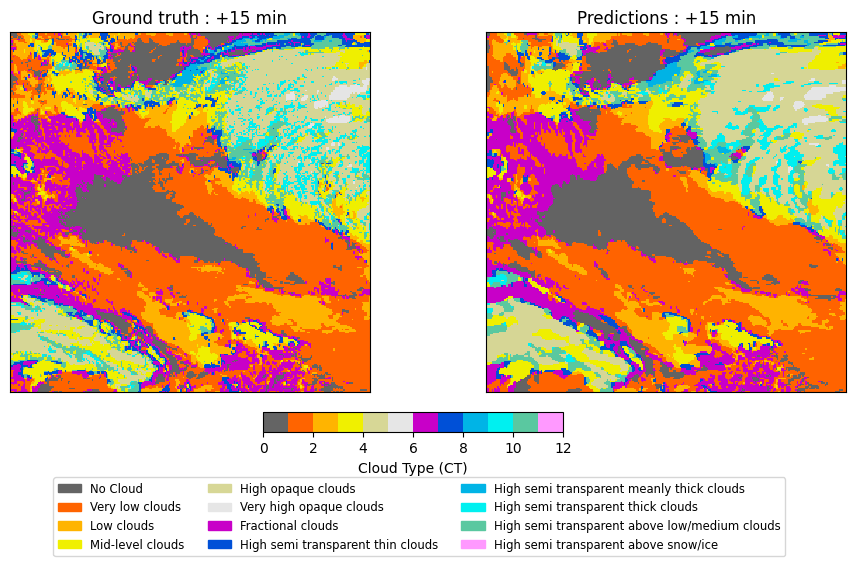

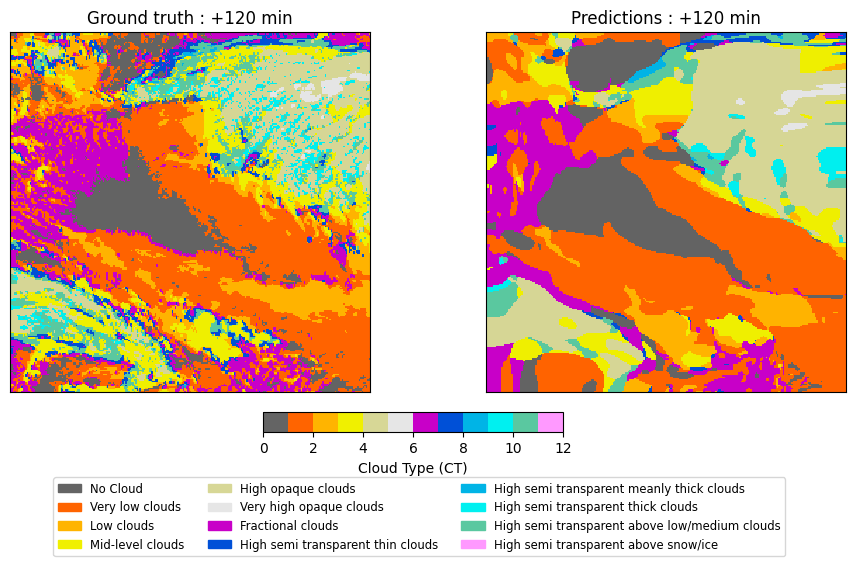

Done
Saved to outputs/202101021200_hyphai-1.gif


In [8]:
# Create and save animation
y_pred = np.argmax(output_array, axis=1)
animation_path = f"outputs/{FNAME}_hyphaicc-1.gif"
make_gif(sample[:CONTEXT_SIZE], y_pred, sample[CONTEXT_SIZE:], save_to=animation_path)

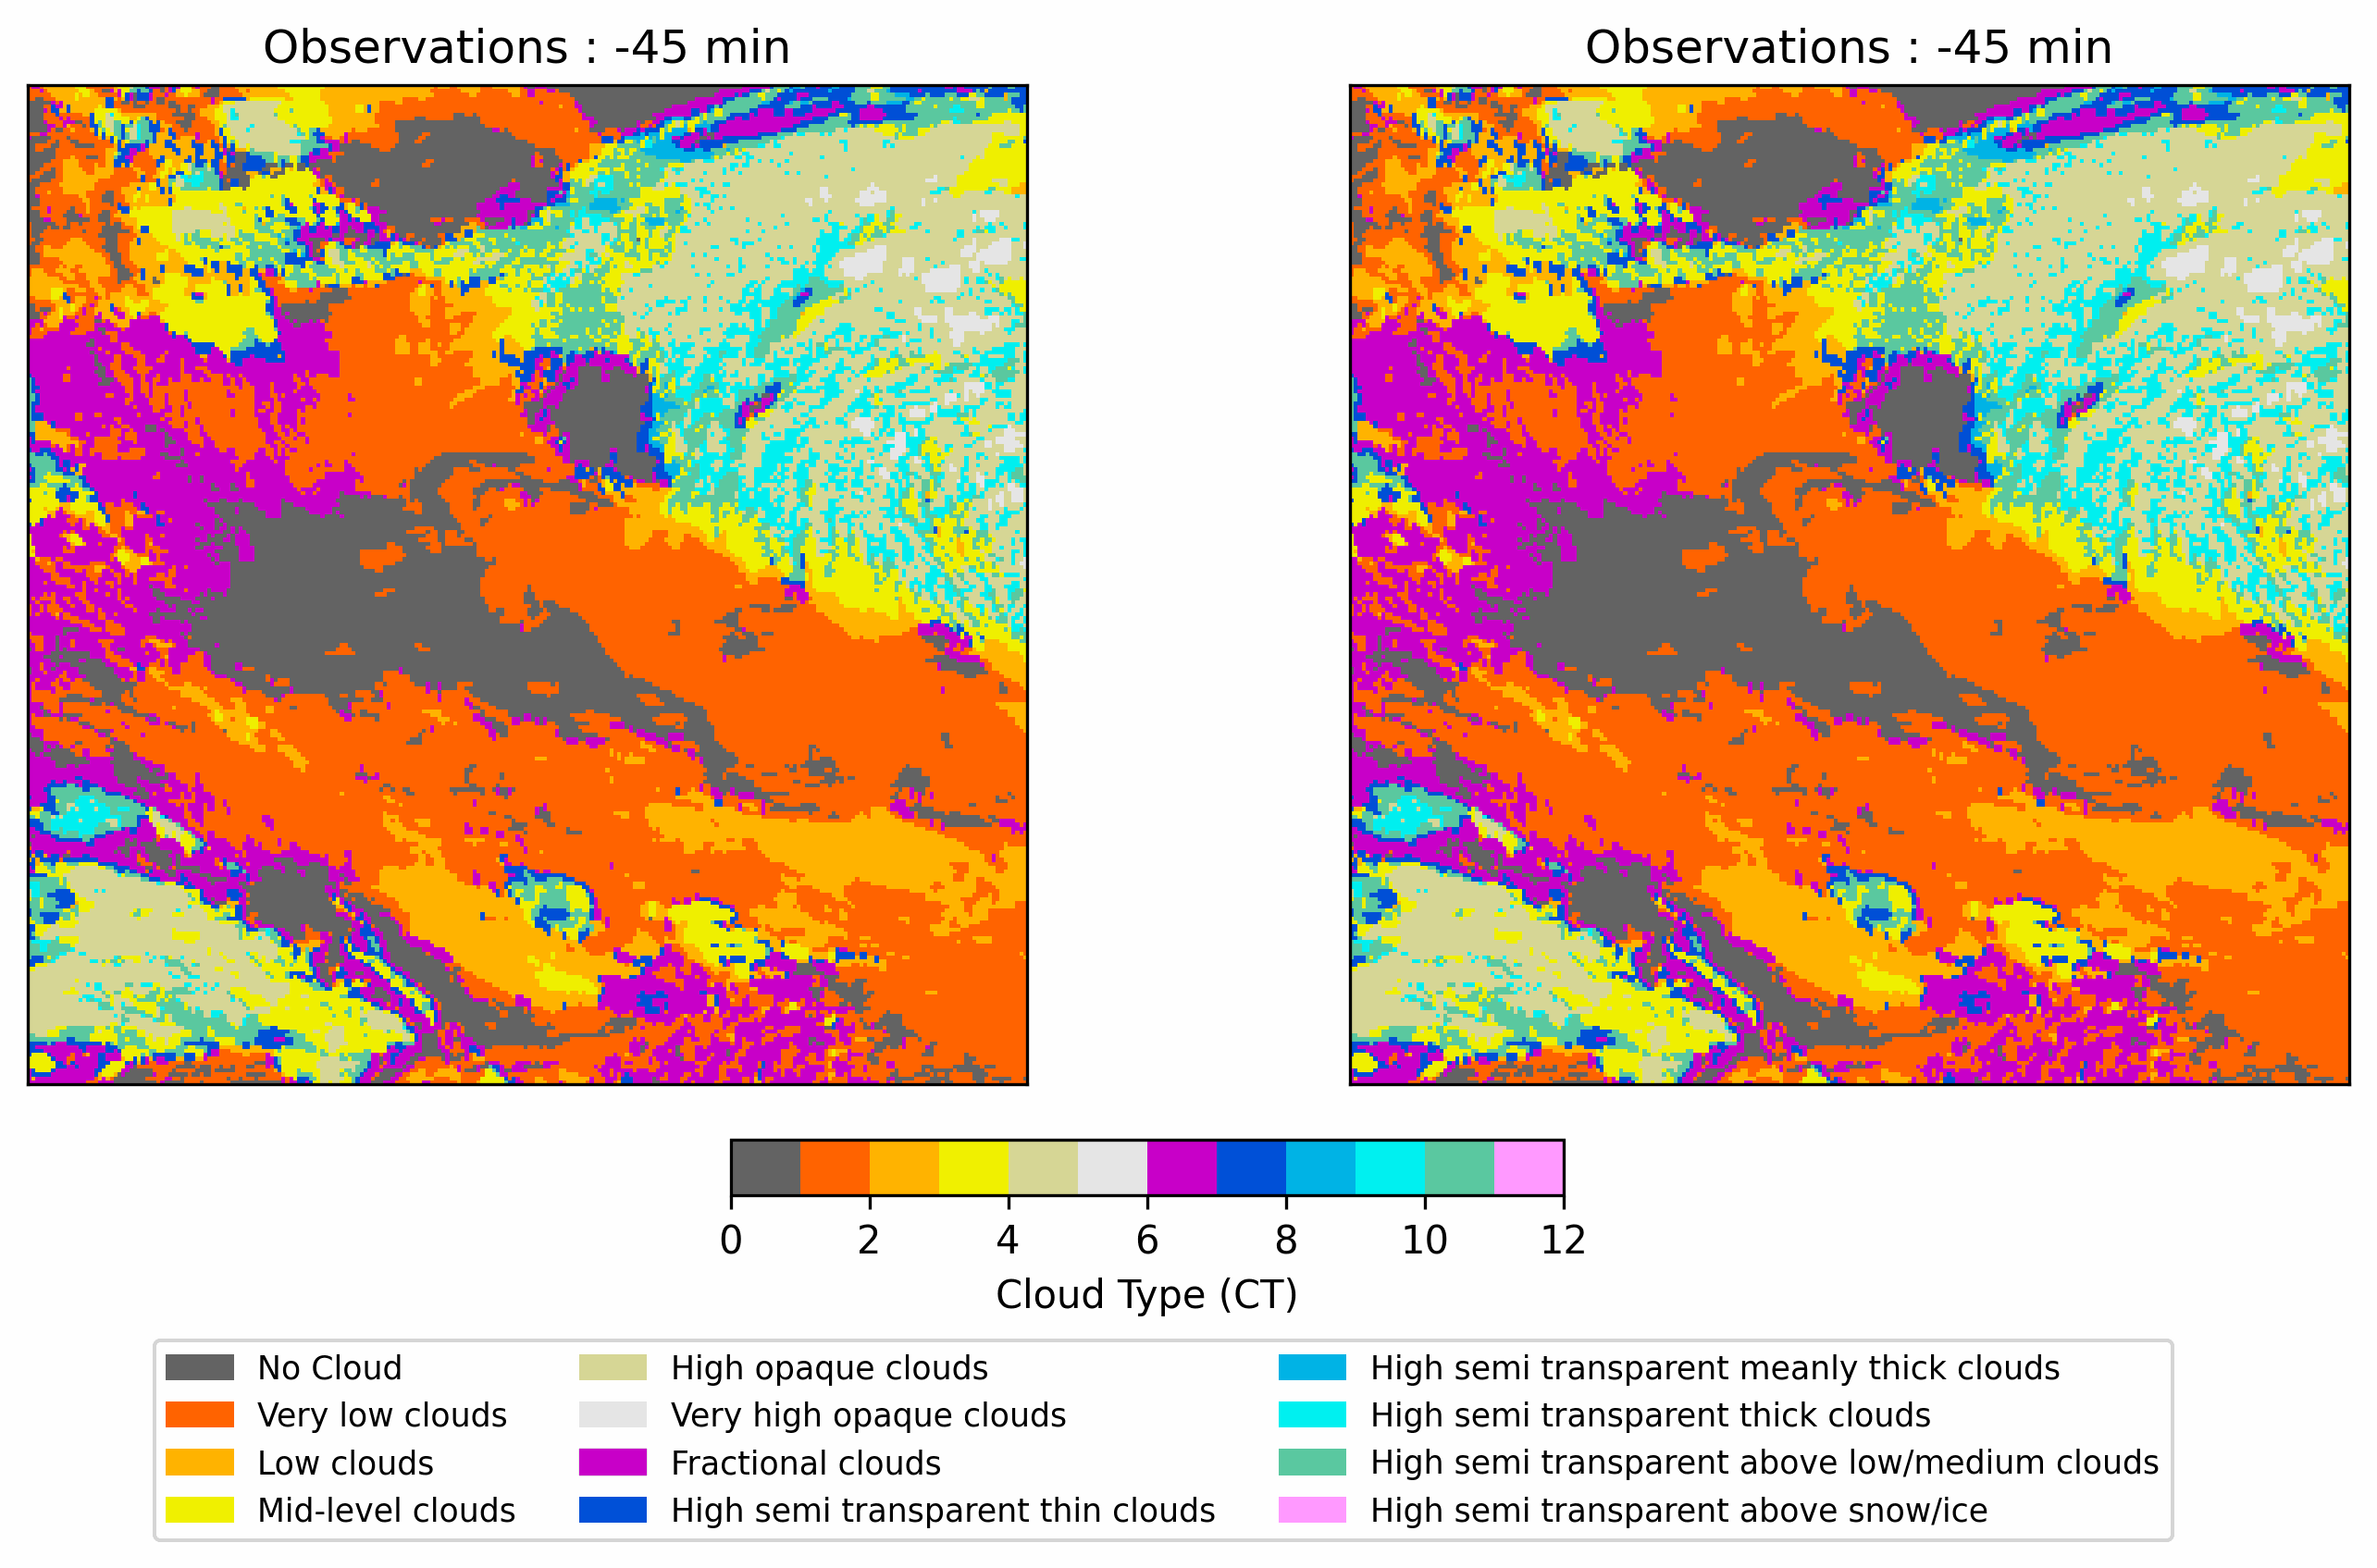

In [9]:
# Display the animation
ipyImage(animation_path)

## Estimated velocity field

/home/algo/elmontassir/hyphai/examples/hyphai/utils.py:183: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{val}' if val < v_max else f'$\geq${v_max}' for val in cbar.get_ticks()])


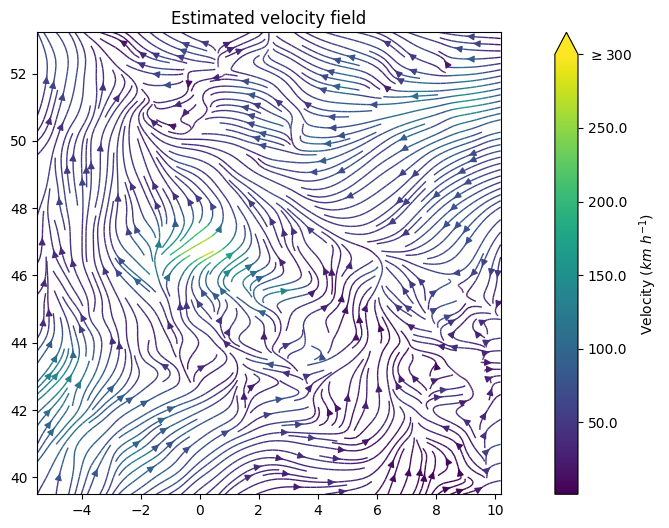

Figure saved to outputs/202101021200_velocity_hyphai-1.pdf


In [10]:
plot_velocity(generated_velocity, save_to=f"outputs/{FNAME}_velocity_hyphaicc-1")